In [31]:
import torch
import numpy as np
import model.dataset as ds
import scipy.signal
import IPython.display
import librosa.display
import matplotlib.pyplot as plt


In [53]:
d = ds.SignalDataset(root_dir='/home/ubuntu/dataset/test_c1', transform=ds.ToTensor(size=(129, 690)))

In [54]:
dataloader = torch.utils.data.DataLoader(d, batch_size=32, shuffle=False)

In [55]:
for i, info in enumerate(dataloader):
    aggregate = info['aggregate']
    ground_truths = info['ground_truths']
    break

In [56]:
print(aggregate.size())
print(ground_truths.size())

torch.Size([3, 2, 690, 129])
torch.Size([3, 690, 2, 258])


In [57]:
def pred2wav(pred, fs=44100):
    processed = pred.numpy().T
    input_dim, num_sources, seq_len = processed.shape
    
    all_data = []
    for i in range(num_sources):
        spect_raw = processed[:, i, :]
        real_comp = np.split(spect_raw, 2)[0]
        imag_comp = np.split(spect_raw, 2)[1]
        spect = real_comp + 1j * imag_comp
    
        _, data = scipy.signal.istft(spect, fs, nfft=256)
        
        all_data.append(data)
    
    return np.array(all_data)

def pred2spect(pred, fs=44100):
    processed = pred.numpy().T
    input_dim, num_sources, seq_len = processed.shape
    
    all_spects = []
    for i in range(num_sources):
        spect_raw = processed[:, i, :]
        real_comp = np.split(spect_raw, 2)[0]
        imag_comp = np.split(spect_raw, 2)[1]
        spect = real_comp + 1j * imag_comp
        
        all_spects.append(spect)
    
    return np.array(all_spects)

In [64]:
all_data = pred2wav(ground_truths[1])
all_spects = pred2spect(ground_truths[1])

In [65]:
all_data.shape

(2, 88192)

In [66]:
def display(spect, sample_rate, y_axis='mel',x_axis='time'):
    db_data = librosa.power_to_db(np.abs(spect)**2, ref=np.max)
    librosa.display.specshow(db_data, sr=sample_rate, y_axis=y_axis, x_axis=x_axis)

In [86]:
data = all_data[1]
IPython.display.Audio(data=data, rate=44100)

(0.0, 2.0027210884353743, 0.0, 11025.0)

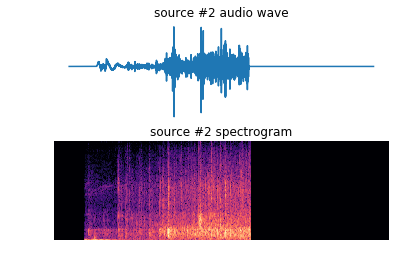

In [87]:
plt.subplot(2, 1, 1)
plt.plot(data)
plt.title('source #2 audio wave')
ax = plt.gca()
plt.axis('off')

plt.subplot(2, 1, 2)
plt.title('source #2 spectrogram')
display(all_spects[1], sample_rate=44100*4)
plt.axis('off')


SDR

In [74]:
import mir_eval.separation as sep
import model.models

In [93]:
sep.validate(all_data, all_data)
sep.bss_eval_sources(all_data, all_data)

(array([230.36890244, 264.51776855, 251.99398784, 239.70814574,
        258.44682688, 294.56341369, 241.14411448]),
 array([246.7409388 , 245.8158631 , 231.53597993, 216.45876727,
        233.11429562, 242.589768  , 204.79484429]),
 array([230.26992136, 245.81574935, 231.53236461, 216.37273864,
        233.05155579, 242.58989281, 204.79552708]),
 array([0, 1, 2, 3, 4, 5, 6]))

In [75]:
net = model.models.LookListen_Base(input_dim=129, seq_len=690, num_sources=2)
net.load_state_dict(torch.load('pretrained_range10/google_checkpoint_euclidean_1_98.pth'))
net.eval()

LookListen_Base(
  (convs): ModuleList(
    (0): Conv2d(2, 6, kernel_size=(1, 7), stride=(1, 1), padding=[0, 3])
    (1): Conv2d(6, 6, kernel_size=(7, 1), stride=(1, 1), padding=[3, 0])
    (2): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2])
    (3): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[4, 4], dilation=(2, 2))
    (4): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[8, 8], dilation=(4, 4))
    (5): Conv2d(6, 6, kernel_size=(5, 5), stride=(1, 1), padding=[16, 16], dilation=(8, 8))
    (6): Conv2d(6, 8, kernel_size=(5, 5), stride=(1, 1), padding=[2, 2])
  )
  (bns): ModuleList(
    (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): BatchNorm2

In [76]:
preds, mask = net(aggregate)

In [83]:
pred_data = pred2wav(preds[1].detach())
pred_spects = pred2spect(preds[1].detach())
mask_spects = pred2spect(mask[1].detach())

torch.Size([3, 690, 2, 258])
torch.Size([3, 690, 2, 258])


(0.0, 2.0027210884353743, 0.0, 11025.0)

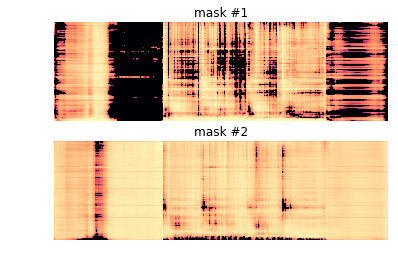

In [90]:
print(mask.shape)

print(mask.shape)
plt.subplot(2, 1, 1)
plt.title('mask #1')
display(mask_spects[0], sample_rate=44100*4)
plt.axis('off')
plt.subplot(2, 1, 2)
plt.title('mask #2')
display(mask_spects[1], sample_rate=44100*4)
plt.axis('off')


In [68]:
bs, _, num_sources, _ = preds.shape
wavs = []
for i in range(bs):
    wavs.append(pred2wav(preds[i].detach()))

wavs = np.array(wavs)
spects = pred2spect(preds[0].detach())
print(wavs.shape)

sep.validate(wavs[0], all_data)
sep.bss_eval_sources(wavs[0], all_data)

(3, 2, 88192)


(array([-2.87753334, 24.28281652]),
 array([ 6.19966736, 37.26523446]),
 array([-1.37031572, 24.50786803]),
 array([1, 0]))

In [76]:
bs, _, num_sources, _ = preds.shape
wavs = []
for i in range(bs):
    wavs.append(pred2wav(preds[i].detach()))

wavs = np.array(wavs)
spects = pred2spect(preds[0].detach())
print(wavs.shape)

sep.validate(wavs[0], all_data)
sep.bss_eval_sources(wavs[0], all_data)

(3, 2, 88192)


(array([24.4004307 , -2.65096981]),
 array([37.43565845,  6.47903545]),
 array([24.62267037, -1.2038226 ]),
 array([0, 1]))

In [78]:
IPython.display.Audio(data=wavs[0][0], rate=44100)